In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
import pathlib
import xarray as xr
import netCDF4 as nc
import dask
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
def monthly_data_prep(folder_path, extension):
    # target_files = [f for f in files if f.endswith(extension)]
    target_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(extension)]

    flattened_frames = []

    for file in target_files: 
        ds = xr.open_dataset(file, engine='netcdf4')
        df = ds.to_dataframe()
        flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
        flattened['valid_time'] = flattened['valid_time'].dt.date
        flattened = flattened.drop(columns=['number'])
        flattened_frames.append(flattened)
        
    flattened_0, flattened_1 = flattened_frames 

    if flattened_0["valid_time"].equals(flattened_1["valid_time"]):
        combined = flattened_0.merge(flattened_1, left_index=True, right_index=True)
        combined = combined.drop(columns=['valid_time_y', 'latitude_y', 'longitude_y'])
        combined = combined.rename(columns={'valid_time_x': 'valid_time', 'latitude_x': 'latitude', 'longitude_x': 'longitude'})
        return combined
    else:
        print('Dataframes do not have the same valid time.')
        return None

- siconc = sea ice concentration
- rsn = snow density
- sst = sea surface temperature
- sd = snow depth
- t2m = 2m temperature
- tp = total percipitation
- avg_smr = average snow melt rate

In [4]:
combined = monthly_data_prep(os.getcwd(), '.nc')

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()


In [5]:
# for the first plot, group by valid time and average over the latitude and longitude
grouped = combined.groupby('valid_time').agg('mean').reset_index()

# restrict timeframe to 1996 - 2017
grouped = grouped[(grouped['valid_time'] >= pd.Timestamp('1996-01-01')) & (grouped['valid_time'] <= pd.Timestamp('2017-12-31'))].reset_index(drop=True)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/849022439.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  grouped = grouped[(grouped['valid_time'] >= pd.Timestamp('1996-01-01')) & (grouped['valid_time'] <= pd.Timestamp('2017-12-31'))].reset_index(drop=True)


In [7]:
# calculate the actual numbers --> means per year, standard deviations per year etc
grouped['valid_time'] = pd.to_datetime(grouped['valid_time'])

grouped['year'] = grouped['valid_time'].dt.year
grouped['month'] = grouped['valid_time'].dt.month


## Calculate statistics for reference period 1961-1990

In [8]:

files_rp = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/monthly_data/reference_period'
print(os.listdir(files_rp))
reference_period_df = monthly_data_prep(folder_path=files_rp, extension= '.nc')

['.DS_Store', 'data_1_rp.nc', 'data_0_rp.nc']


/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()
/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/4014924273.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flattened = df.groupby(['valid_time', 'latitude', 'longitude']).sum().reset_index()


## Center Data around Reference period

In [9]:
 # center all columns at their mean and make individual values percentages:
 # 1961 -1990 als Referenzperiode nehmen! 

rp_grouped = reference_period_df.groupby('valid_time').agg('mean').reset_index()

In [10]:
columns = rp_grouped.columns[3:]
# calculate climate anomalies
grouped_anomaly = grouped.copy()
for column in columns:
    grouped_anomaly[column] = (grouped[column] - rp_grouped[column].mean()) / rp_grouped[column].std()

## Monthly Plots

In [11]:
titles = {'siconc': 'Sea Ice Concentration', 'rsn': 'Snow Density', 'sst': 'Sea Surface Temperature', 'sd': 'Snow Depth', 't2m': '2m Temperature', 'tp': 'Total Precipitation', 'avg_smr': 'Average Snowmelt Rate'}

def plot_monthly(df, columns, deg):

    # only keep values from years 1996, 2000, 2004, 2008, 2012, 2016
    df = df[df['year'].isin([1996,  2003,  2010, 2017])]
    


    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        # get title from titles dictionary
        title = titles[column]

        #scatter = plt.scatter(df['month'], df[column], c = 'black')
        scatter = plt.scatter(df['month'], df[column], 
                          c=df['year'], cmap='viridis')
    
        # Add colorbar
        plt.colorbar(scatter, label='Year')


        # # add regression line
        # z = np.polyfit(df['month'], df[column], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        # p = np.poly1d(z)
        # plt.plot(df['month'],p(df['month']), linestyle = "-", c = 'red', linewidth = 0.3)


        plt.xlabel('month')
        plt.title(title)
        plt.tight_layout()
        plt.show()

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/3741837649.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_monthly = grouped_anomaly.groupby(['year', 'month']).agg('mean').reset_index()


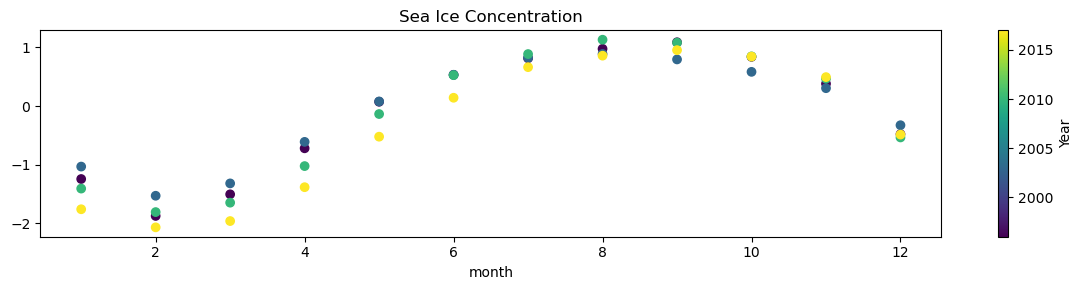

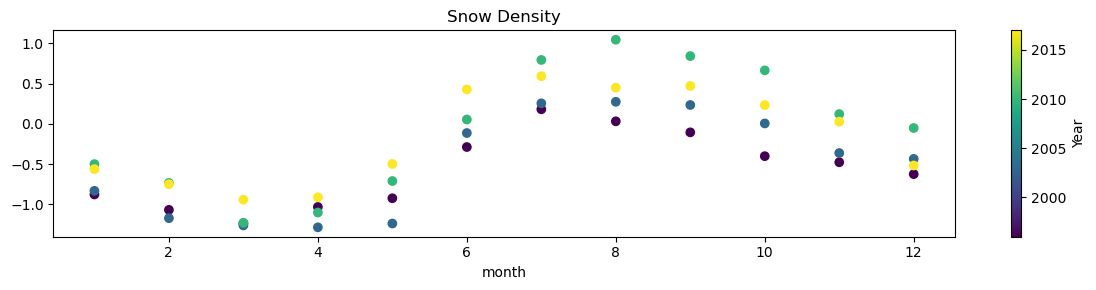

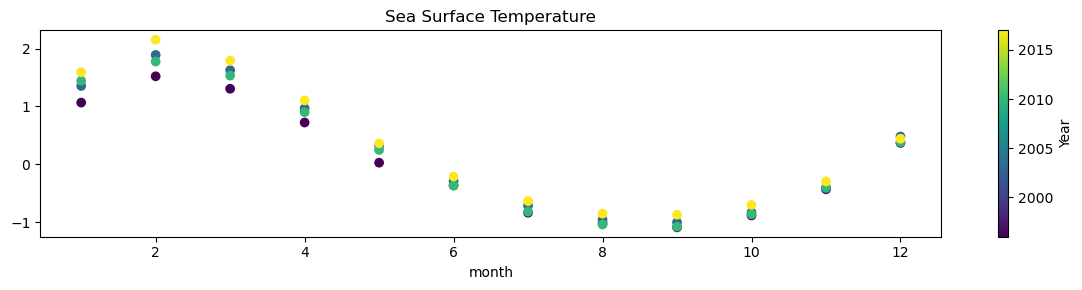

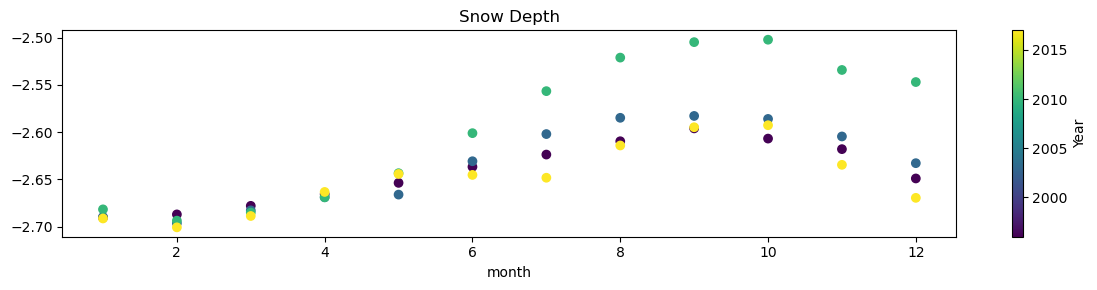

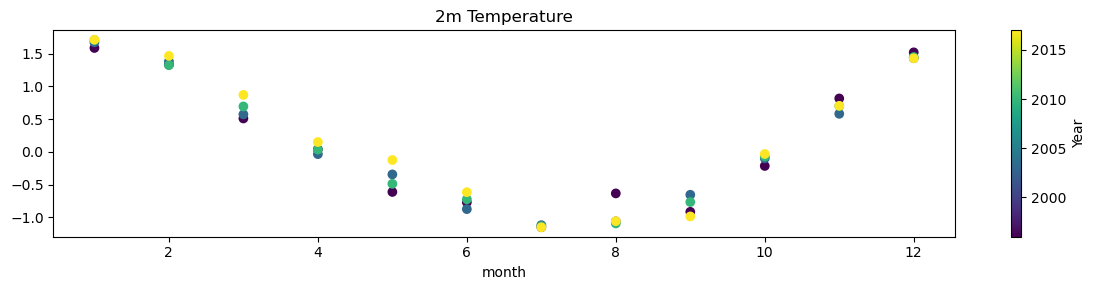

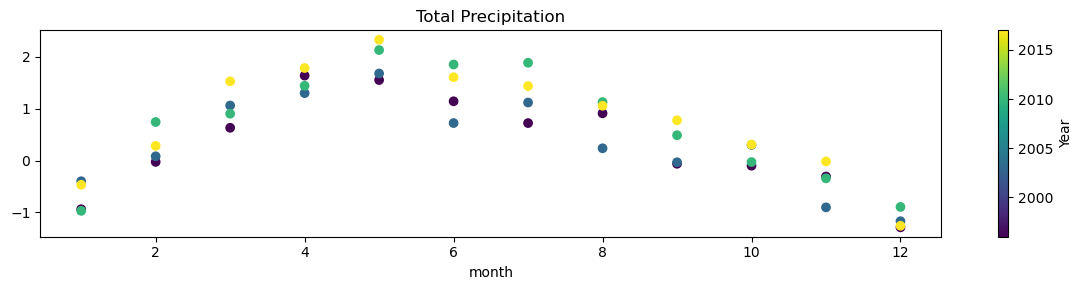

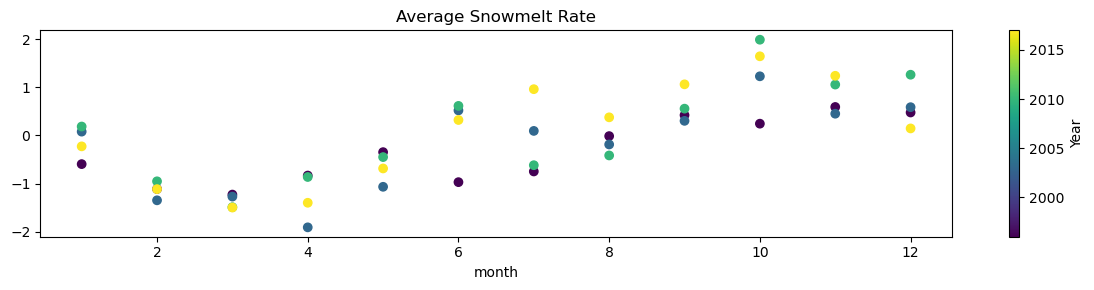

In [12]:
means_monthly = grouped_anomaly.groupby(['year', 'month']).agg('mean').reset_index()
columns = means_monthly.columns[4:]
plot_monthly(means_monthly, columns, 1)

## Yearly Plots


In [13]:
grouped_anomaly['valid_time'] = pd.to_datetime(grouped_anomaly['valid_time'])

In [14]:
grouped_anomaly['year'] = grouped_anomaly['valid_time'].dt.year
grouped_anomaly['month'] = grouped_anomaly['valid_time'].dt.month

def plot_yearly(df, columns, deg):


    for column in columns:
        plt.figure(figsize=(12, 3))
        
        # for each column, use only rows that dont have zero values
        df = df[df[column] != 0]

        title = titles[column]

        scatter = plt.scatter(df['year'], df[column], c = 'black')

        # add regression line
        z = np.polyfit(df['year'], df[column], deg)   # Hier 1, 2, 3, oder 4 degs rein?
        p = np.poly1d(z)
        plt.plot(df['year'],p(df['year']), linestyle = "-", c = 'red', linewidth = 0.3)


        plt.xlabel('Year')
        plt.title(title)
        plt.tight_layout()
        plt.show()


/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/2073532081.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped_anomaly.groupby('year').agg('mean').reset_index()


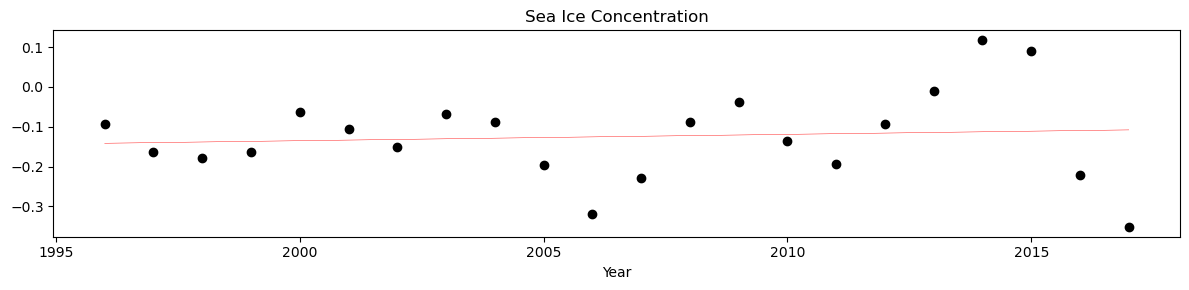

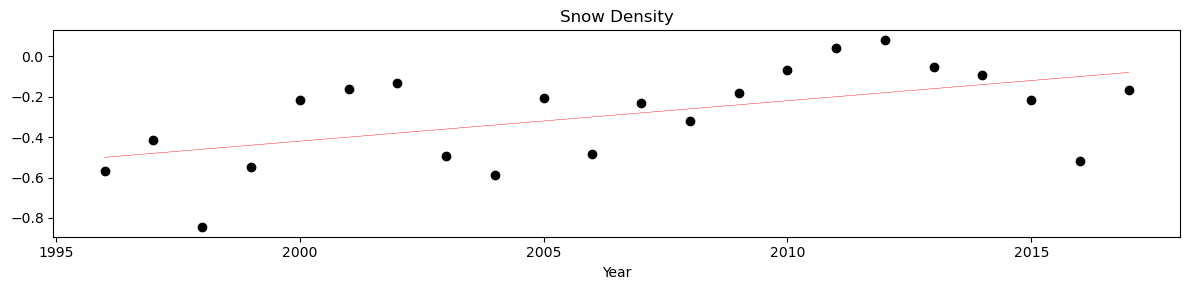

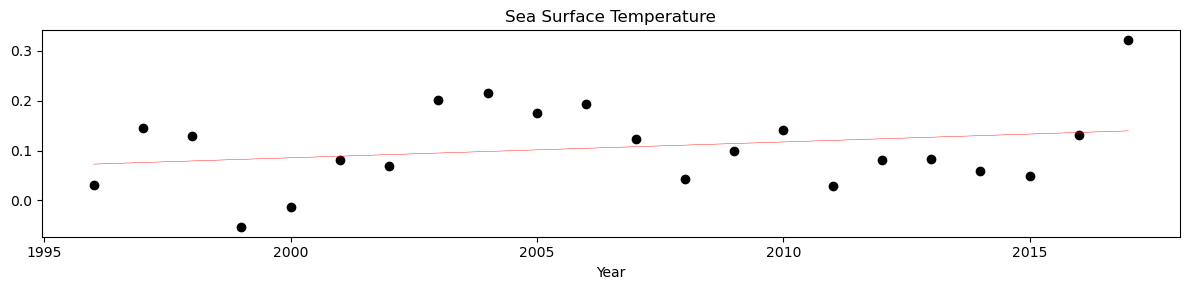

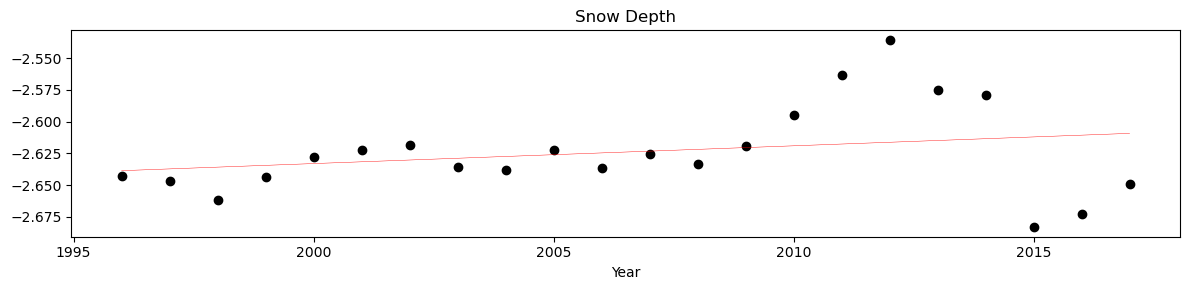

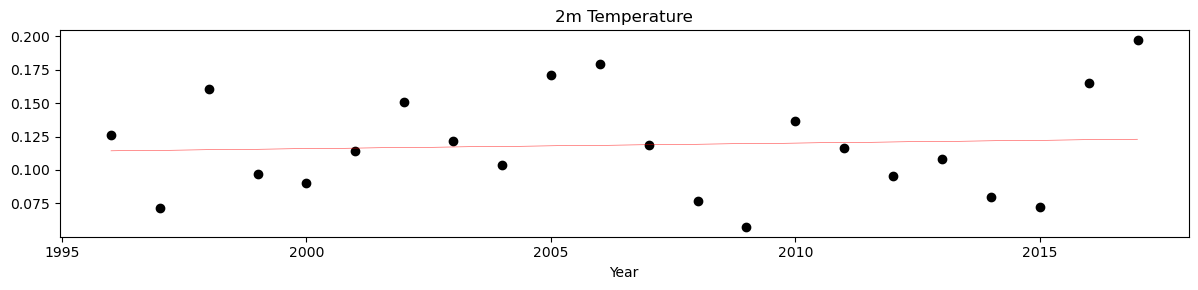

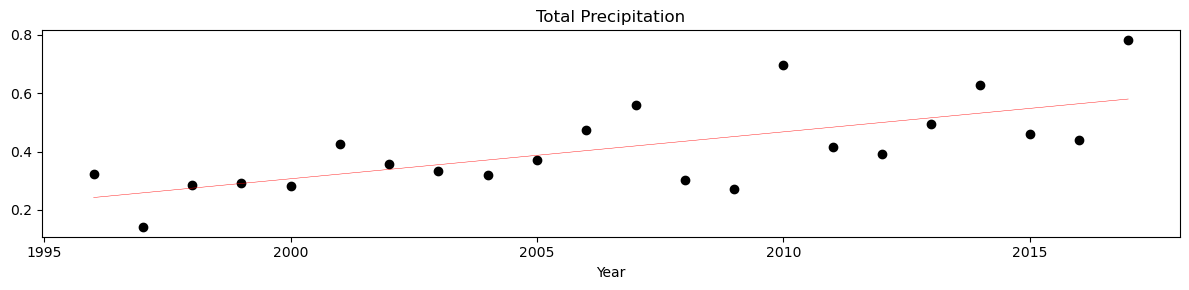

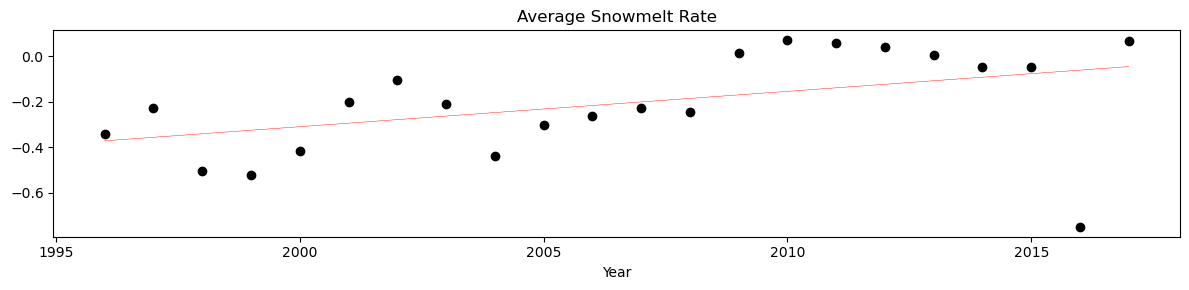

In [15]:
means = grouped_anomaly.groupby('year').agg('mean').reset_index()
plot_yearly(means, columns, 1)

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/2001310195.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = grouped_anomaly.groupby('year').agg('std').reset_index()


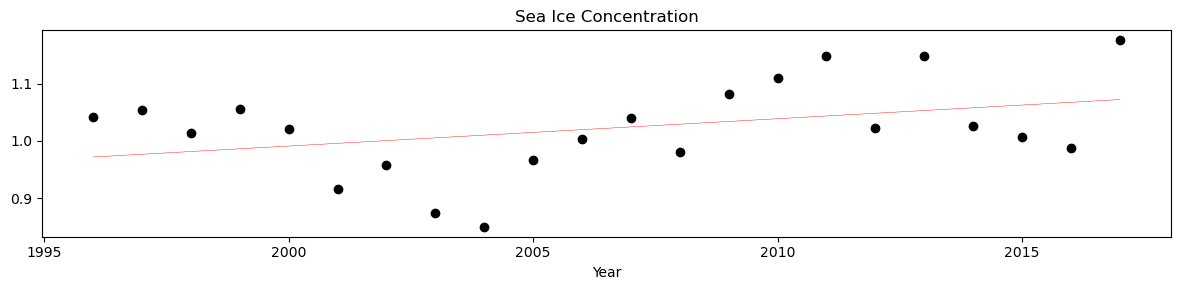

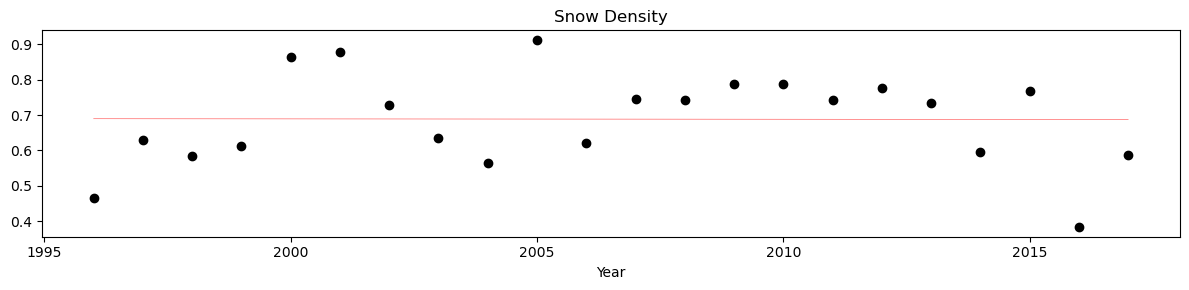

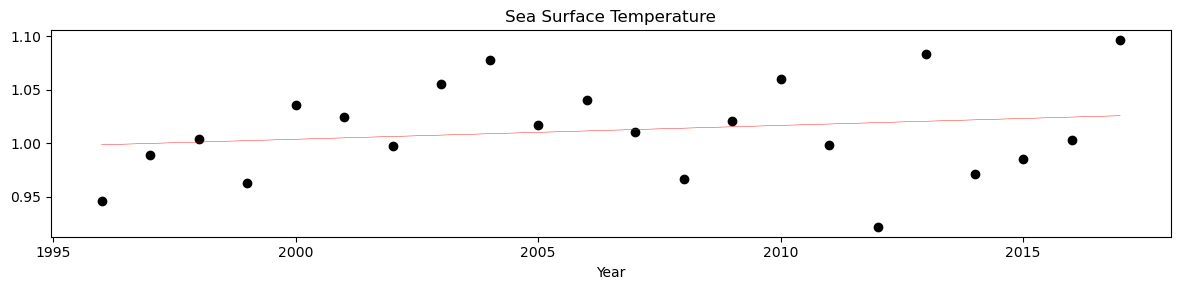

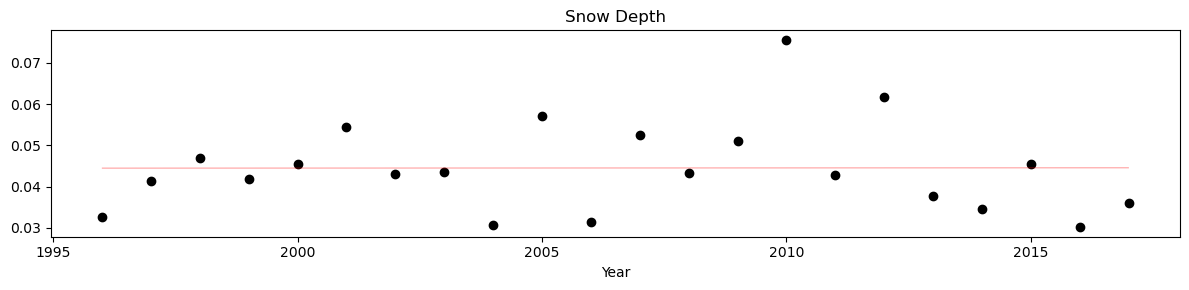

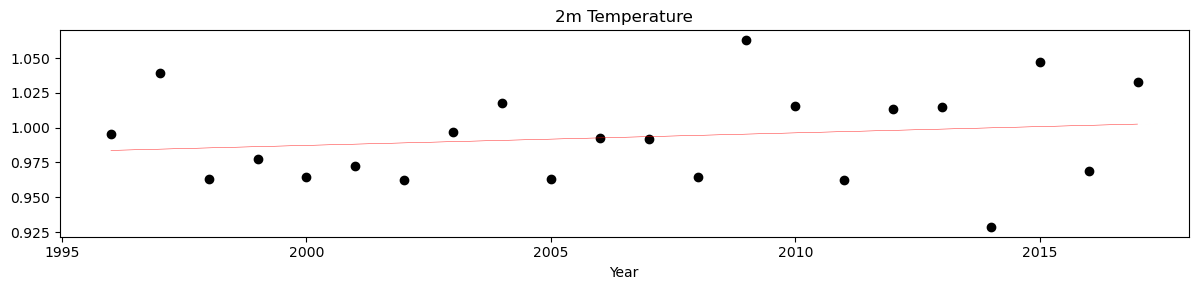

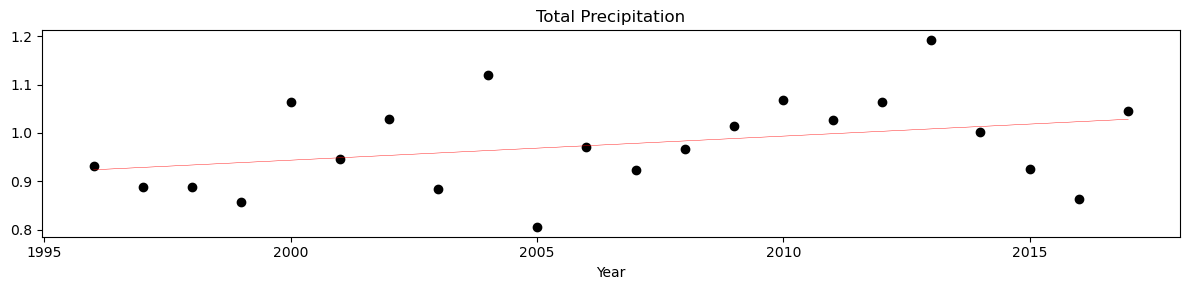

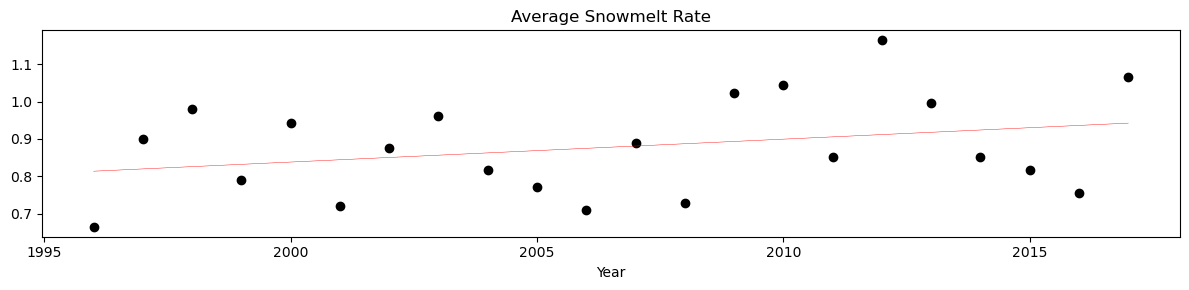

In [16]:
# standard deviations per year
stds = grouped_anomaly.groupby('year').agg('std').reset_index()

plot_yearly(stds, columns, 1)

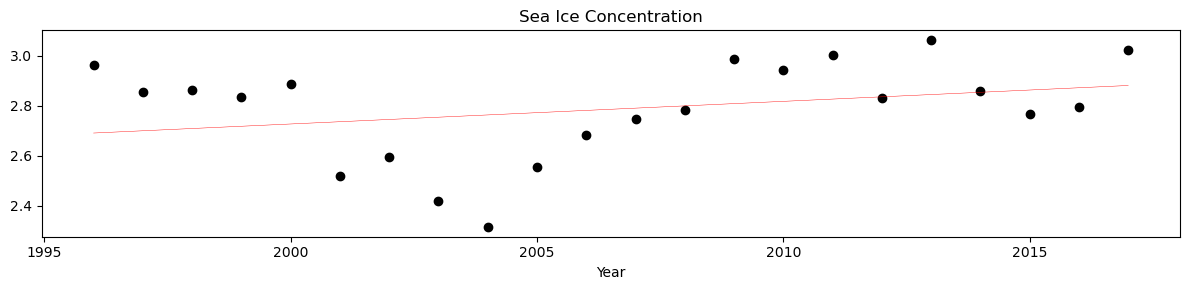

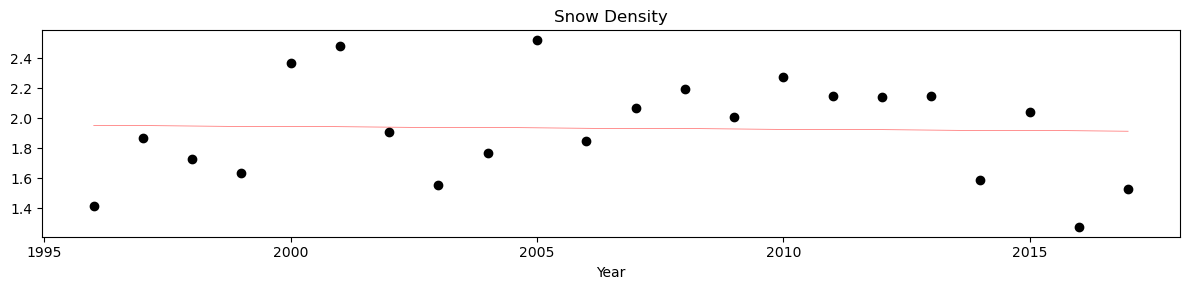

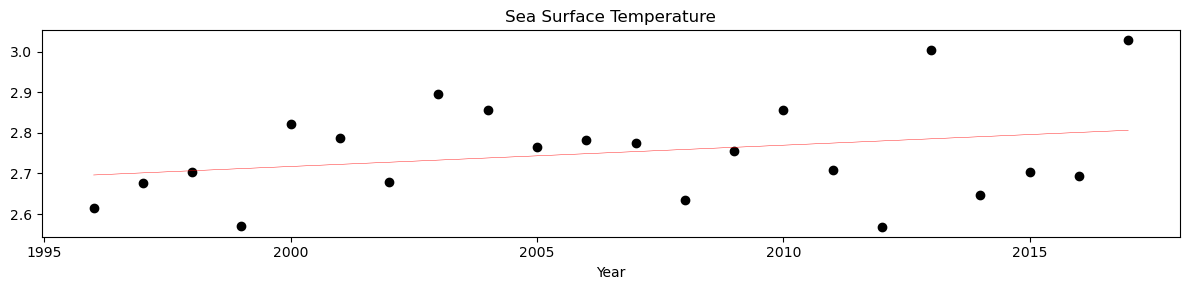

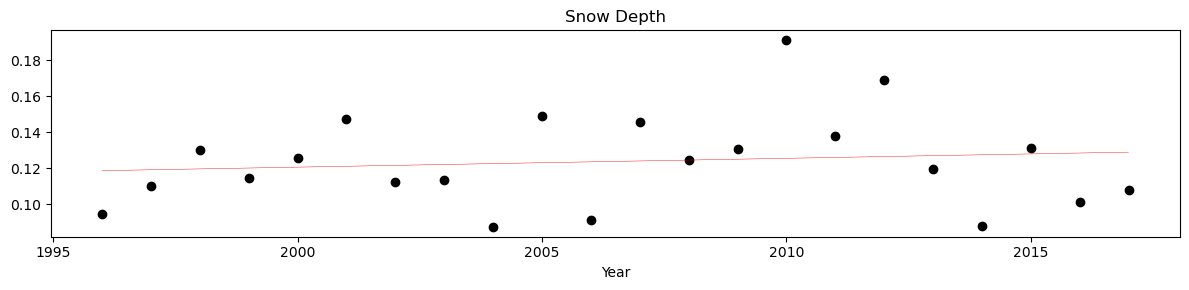

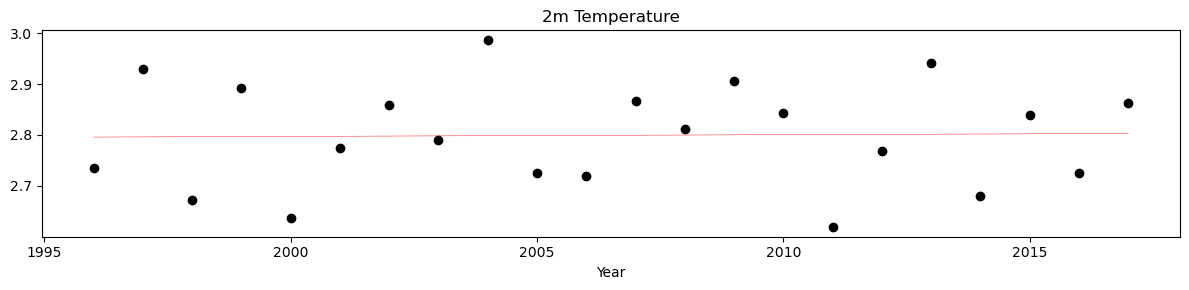

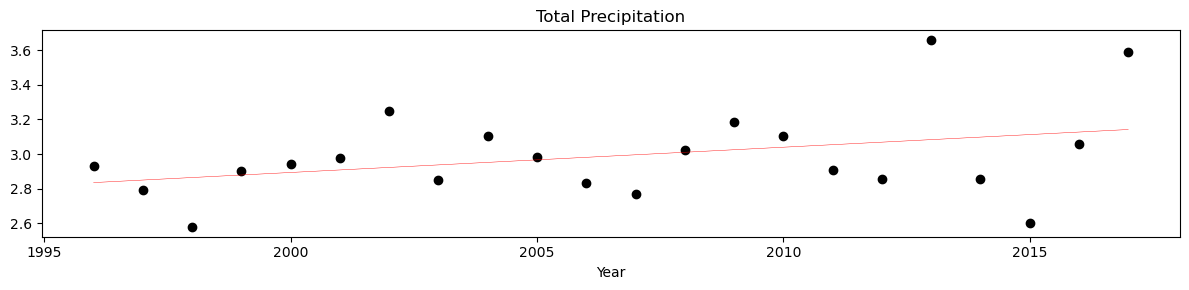

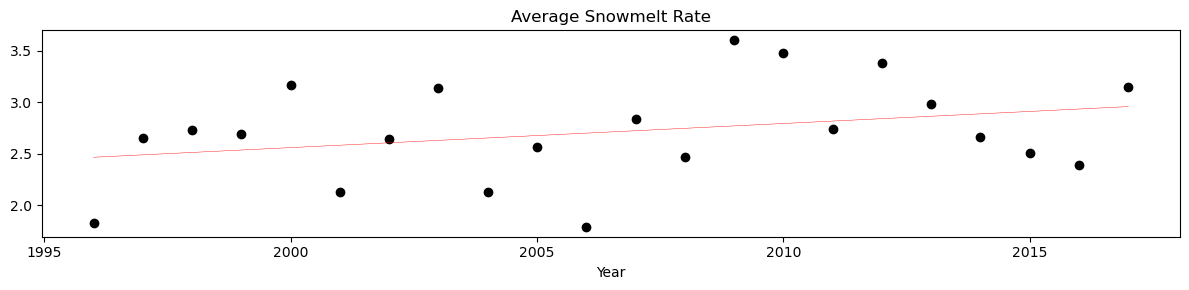

In [17]:
# plot spread per year
mins = grouped_anomaly.groupby('year').agg('min').reset_index()
maxs = grouped_anomaly.groupby('year').agg('max').reset_index()

diff = maxs.copy()
diff[columns] = maxs[columns] - mins[columns]

plot_yearly(diff, columns, 1)#xyz

/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23782/2988842444.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stationary = stationary.groupby('year').agg('mean').reset_index()


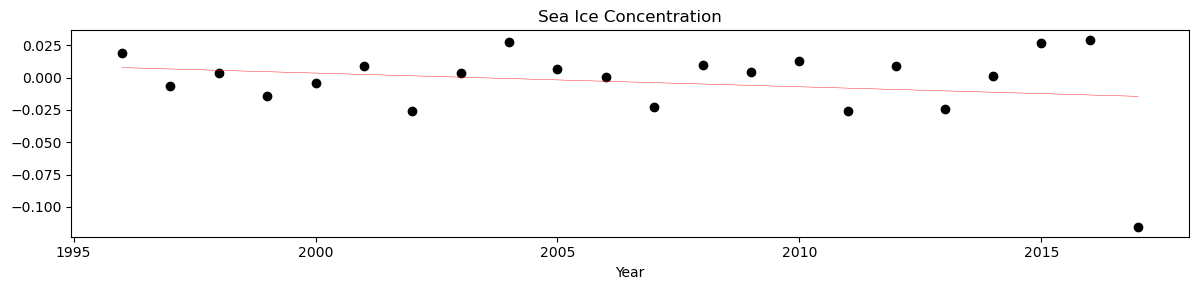

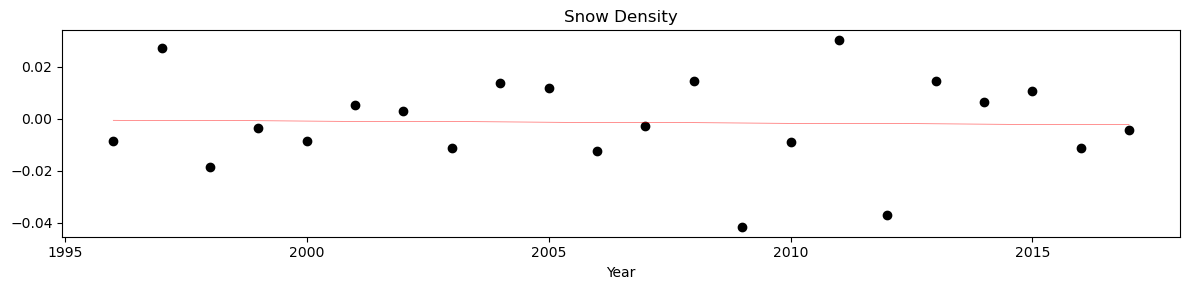

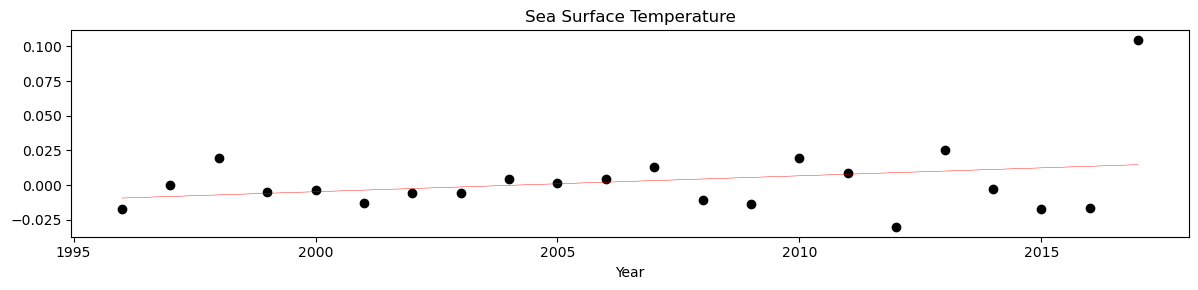

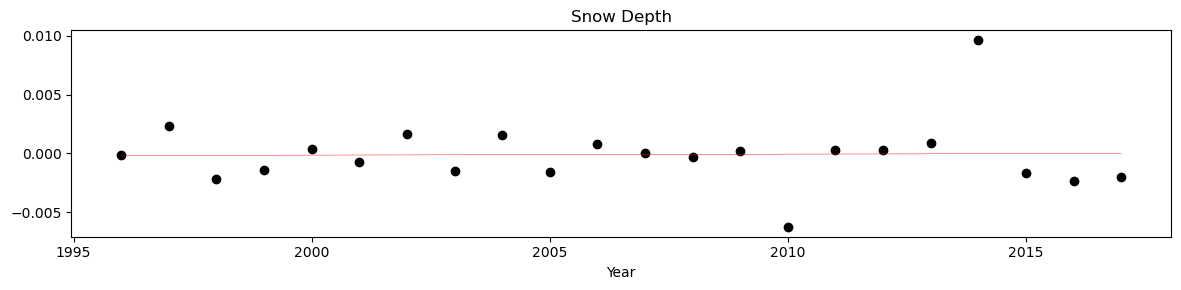

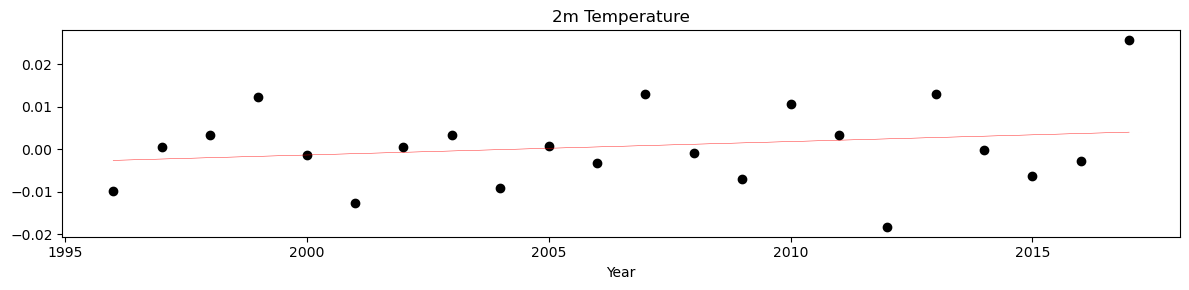

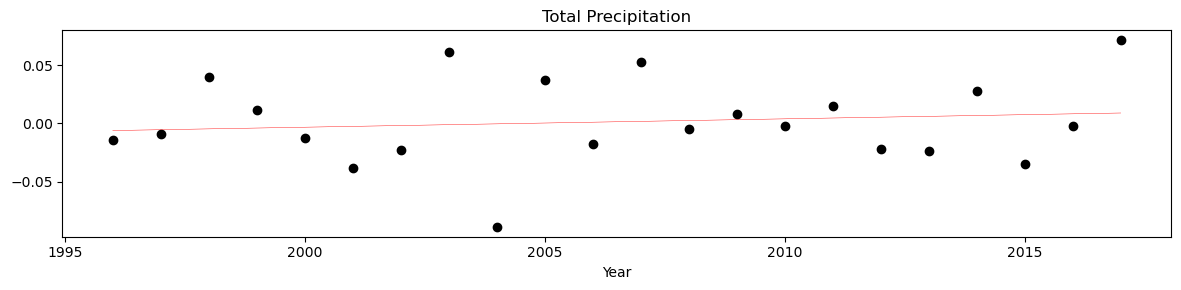

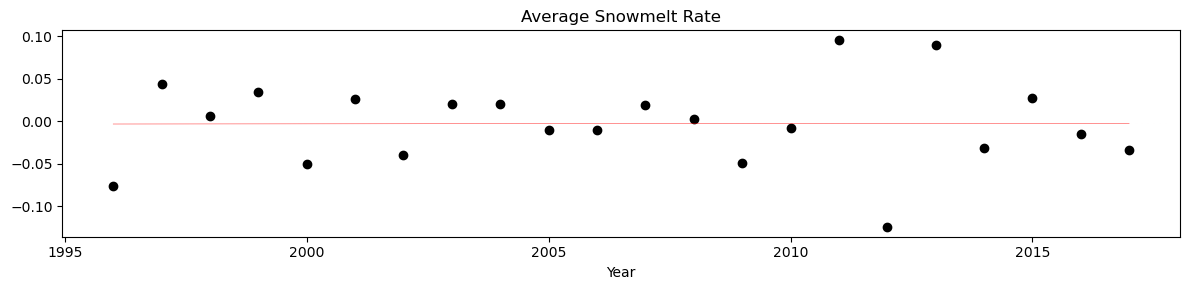

In [18]:
# make it stationary and plot the differences
stationary = grouped_anomaly.copy()
stationary[columns] = stationary[columns]-stationary[columns].shift(-1)

stationary = stationary.groupby('year').agg('mean').reset_index()

plot_yearly(stationary, columns, 1)